# ¿Cuál es un mejor plan?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [79]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import math
from scipy import stats as st
import matplotlib.pyplot as plt
from statistics import mode

## Cargar los datos

In [80]:
# Carga los archivos de datos en diferentes DataFrames
df_calls = pd.read_csv('/datasets/megaline_calls.csv')
df_internet = pd.read_csv('/datasets/megaline_internet.csv')
df_messages = pd.read_csv('/datasets/megaline_messages.csv')
df_plans = pd.read_csv('/datasets/megaline_plans.csv')
df_users = pd.read_csv('/datasets/megaline_users.csv')

## Preparar los datos

## Planes

In [81]:
# Imprime la información general/resumen sobre el DataFrame de los planes
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [82]:
# Imprime una muestra de los datos para los planes
df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Corregir los datos

In [83]:
df_plans['mb_per_month_included'] = df_plans['mb_per_month_included']/1024
df_plans.rename(columns={'mb_per_month_included':'gb_per_month_included'},inplace=True)

In [84]:
df_plans.head()

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


En el dataframe df_plans se realizó la conversión de mb a gb para la columna mb_per_month_included y se renombró la column

## Enriquecer los datos

No se observan datos que se requieran adicional al dataframe.

## Usuarios

In [85]:
# Imprime la información general/resumen sobre el DataFrame de los usuarios
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [86]:
# Imprime una muestra de los datos para los usuarios
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [87]:
df_users.describe()

,user_id,age
count,500.000000,500.000000
mean,1249.500000,45.486000
std,144.481833,16.972269
min,1000.000000,18.000000
25%,1124.750000,30.000000
50%,1249.500000,46.000000
75%,1374.250000,61.000000
max,1499.000000,75.000000


Con el método describe observamos que las columnas numéricas no presentan valores atípicos

In [88]:
df_users.duplicated().sum()

0

Observamos que no hay valores duplicados en el dataframe

En el dataframe df_users observamos que hay tipos de datos por cambiar y usuarios que aún cuentan con el servicio activo y otros que no.

### Corregir datos

In [89]:
def active_service(row):
    if pd.isna(row['churn_date']):
        return 0
    else:
        return 1

In [90]:
df_users['active_service'] = df_users.apply(active_service, axis=1)

In [91]:
df_users.head(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,active_service
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,0
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,0
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,0
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,0
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,0
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN,0
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN,0
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN,0
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN,0


In [92]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d', errors='coerce')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d', errors='coerce')

In [93]:
df_users.rename(columns={'plan':'plan_name'},inplace=True)

Se agregó la columna active_service para tener mayor visibilidad de si el usuario cuenta con un plan activo. Adicionalmente cambiamos el tipo de datos de las columnas reg_date y churn_date al tipo date time.

### Enriquecer datos

Observamos que al modificar los tipos de datos, el dataframe no requiere mayores cambios.

In [94]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         500 non-null    int64         
 1   first_name      500 non-null    object        
 2   last_name       500 non-null    object        
 3   age             500 non-null    int64         
 4   city            500 non-null    object        
 5   reg_date        500 non-null    datetime64[ns]
 6   plan_name       500 non-null    object        
 7   churn_date      34 non-null     datetime64[ns]
 8   active_service  500 non-null    int64         
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 35.3+ KB


## Llamadas

In [95]:
# Imprime la información/resumen general sobre el DataFrame de las llamadas
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [96]:
# Imprime una muestra de datos para llamadas
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Observamos que el dataframe df_calls únicamente requiere ajustar algunos tipos de datos.

In [97]:
df_calls.describe()

,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


Con el método describe observamos que las columnas numéricas no presentan valores atípicos

In [98]:
df_calls.duplicated().sum()

0

Observamos que no hay valores duplicados en el dataframe

### Corregir datos

In [99]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')

In [100]:
no_duration = df_calls[df_calls['duration'] == 0]
print('Porcentaje de llamadas en 0:')
print(100* len(no_duration)/len(df_calls))

Porcentaje de llamadas en 0:
19.48233927469416


Se revisa la cantidad de llamadas en 0, ya que pueden tratarse de llamadas perdidas y si el porcentaje fuese mayor, debería revisarse a mayor detalle.

### Enriquecer datos

Redondeamos el valor de la duración de las llamadas.

In [101]:
#Redondeamos duracion de las llamadas
df_calls['duration'] = df_calls['duration'].apply(np.ceil)
df_calls['duration'] = df_calls['duration'].astype('int64')

In [102]:
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month

In [103]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
 4   month      137735 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.3+ MB


Ya que las llamadas se redondean individualmente a minutos hacia arriba, redondamos y convertimos los datos de flotante a enteros.

## Mensajes

In [104]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [105]:
# Imprime una muestra de datos para los mensajes
df_messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Al dataframe df_messages al igual que los anteriores únicamente será necesarios algunos cambios de tipo de datos.

In [106]:
df_messages.describe()

,user_id
count,76051.000000
mean,1245.972768
std,139.843635
min,1000.000000
25%,1123.000000
50%,1251.000000
75%,1362.000000
max,1497.000000


Con el método describe observamos que las columnas numéricas no presentan valores atípicos

In [107]:
df_messages.duplicated().sum()

0

Observamos que no hay valores duplicados en el dataframe

### Corregir datos

In [108]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')

### Enriquecer datos

Se agrega una columna month que será utilizada posteriormente.

In [109]:
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month

In [110]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.3+ MB


## Internet

In [111]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [112]:
# Imprime una muestra de datos para el tráfico de internet
df_internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Al dataframe df_internet se realizan ajustes del tipo de datos de algunas columnas.

In [113]:
df_internet.describe()

,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


Con el método describe observamos que las columnas numéricas no presentan valores atípicos

In [114]:
df_internet.duplicated().sum()

0

Observamos que no hay valores duplicados en el dataframe

### Corregir datos

In [115]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')

In [116]:
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month

### Enriquecer datos

In [117]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.0+ MB


## Estudiar las condiciones del plan

In [118]:
# Imprime las condiciones del plan y asegúrate de que te resulten claros
df_plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario

En esta sección calculamos el número de llamadas hechas por cada usuario, así como la cantidad de minutos que uso por cada usuario por mes.

In [119]:
# Calcula el número de llamadas hechas por cada usuario por mes. Guarda el resultado.
# Calcula la cantidad de minutos que usó cada usuario por mes. Guarda el resultado.
df_calls_duration_per_month =  df_calls.groupby(['user_id','month'])['duration'].agg(['count','sum'])
df_calls_duration_per_month

count  sum
user_id month            
1000    12        16  124
1001    8         27  182
        9         49  315
        10        65  393
        11        64  426
...              ...  ...
1498    12        39  339
1499    9         41  346
        10        53  385
        11        45  308
        12        65  496

[2258 rows x 2 columns]

In [120]:
# Calcula el número de mensajes enviados por cada usuario por mes. Guarda el resultado.
df_messages_per_month = df_messages.pivot_table(index=['user_id','month'], values='id', aggfunc='count')
df_messages_per_month

id
user_id month    
1000    12     11
1001    8      30
        9      44
        10     53
        11     36
...            ..
1496    9      21
        10     18
        11     13
        12     11
1497    12     50

[1806 rows x 1 columns]

In [121]:
# Calcula el volumen del trafico de internet usado por cada usuario por mes. Guarda el resultado.
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month

df_internet_per_month = df_internet.pivot_table(index=['user_id','month'], values='mb_used', aggfunc='sum')
df_internet_per_month

mb_used
user_id month          
1000    12      1901.47
1001    8       6919.15
        9      13314.82
        10     22330.49
        11     18504.30
...                 ...
1498    12     23137.69
1499    9      12984.76
        10     19492.43
        11     16813.83
        12     22059.21

[2277 rows x 1 columns]

In [122]:
df_internet_per_month['mb_used'] = df_internet_per_month['mb_used']/1024
df_internet_per_month.rename(columns={'mb_used':'gb_used'},inplace=True)
df_internet_per_month['gb_used'] = df_internet_per_month['gb_used'].apply(np.ceil)
df_internet_per_month['gb_used'] = df_internet_per_month['gb_used'].astype('int64')
df_internet_per_month

gb_used
user_id month         
1000    12           2
1001    8            7
        9           14
        10          22
        11          19
...                ...
1498    12          23
1499    9           13
        10          20
        11          17
        12          22

[2277 rows x 1 columns]

Calculamos la cantidad de megabytes usados por mes y se redondean hacia arriba.

Combinamos las tablas anteriores en un único dataframe que permita un mejor análisis de los datos.

In [123]:
df_final = pd.merge(df_calls_duration_per_month, df_messages_per_month, on=['user_id', 'month'])
df_final = pd.merge(df_final, df_internet_per_month, on=['user_id', 'month'])
df_final.reset_index(inplace=True)
df_final = df_final.rename(columns={'count': 'calls_placed', 'sum': 'minutes_used' ,'id': 'messages_used'})
df_final

,user_id,month,calls_placed,minutes_used,messages_used,gb_used
0,1000,12,16,124,11,2
1,1001,8,27,182,30,7
2,1001,9,49,315,44,14
3,1001,10,65,393,53,22
4,1001,11,64,426,36,19
...,...,...,...,...,...,...
1754,1496,9,52,414,21,17
1755,1496,10,46,317,18,14
1756,1496,11,39,308,13,9
1757,1496,12,40,294,11,17


In [124]:
# Añade la información del plan
df_final = pd.merge(df_final, df_users, on='user_id')
df_final = pd.merge(df_final, df_plans, on='plan_name')

Agregamos la información respecto a los planes y lo que incluyen para calcular el pago de cada usuario.

In [125]:
df_final.head()

,user_id,month,calls_placed,minutes_used,messages_used,gb_used,first_name,last_name,age,city,...,plan_name,churn_date,active_service,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,12,16,124,11,2,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,ultimate,NaT,0,1000,30.0,3000,70,7,0.01,0.01
1,1006,11,2,10,15,3,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,ultimate,2018-12-18,1,1000,30.0,3000,70,7,0.01,0.01
2,1006,12,9,59,139,32,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,ultimate,2018-12-18,1,1000,30.0,3000,70,7,0.01,0.01
3,1008,10,71,476,21,17,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,ultimate,NaT,0,1000,30.0,3000,70,7,0.01,0.01
4,1008,11,63,446,37,24,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,ultimate,NaT,0,1000,30.0,3000,70,7,0.01,0.01


Generamos columnas que nos permiten saber el excedente de uso de minutos, mensajes y megabytes para poder calculas el ingreso mensual de cada usuario.

In [126]:
# Calcula el ingreso mensual para cada usuario

def extra_messages(row):
    if row['messages_included'] - row['messages_used'] < 0:
        return int(abs(row['messages_included'] - row['messages_used']))
    else:
        return int(0)
    
def extra_minutes(row):
    if row['minutes_included'] - row['minutes_used'] < 0:
        return int(abs(row['minutes_included'] - row['minutes_used']))
    else:
        return int(0)
    
def extra_gb(row):
    if row['gb_per_month_included'] - row['gb_used'] < 0:
        return int(abs(row['gb_per_month_included'] - row['gb_used']))
    else:
        return int(0)
    

df_final['extra_messages'] = df_final.apply(extra_messages, axis=1)
df_final['extra_minutes'] = df_final.apply(extra_minutes, axis=1)
df_final['extra_gb'] = df_final.apply(extra_gb, axis=1)

df_final['payment'] = df_final['usd_monthly_pay'] + (df_final['extra_messages']*df_final['usd_per_message']) + (df_final['extra_minutes']*df_final['usd_per_minute']) + (df_final['extra_gb']*df_final['usd_per_gb'])

df_final.head()


,user_id,month,calls_placed,minutes_used,messages_used,gb_used,first_name,last_name,age,city,...,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,extra_messages,extra_minutes,extra_gb,payment
0,1000,12,16,124,11,2,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,30.0,3000,70,7,0.01,0.01,0,0,0,70.0
1,1006,11,2,10,15,3,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,30.0,3000,70,7,0.01,0.01,0,0,0,70.0
2,1006,12,9,59,139,32,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,30.0,3000,70,7,0.01,0.01,0,0,2,84.0
3,1008,10,71,476,21,17,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,30.0,3000,70,7,0.01,0.01,0,0,0,70.0
4,1008,11,63,446,37,24,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,30.0,3000,70,7,0.01,0.01,0,0,0,70.0


Generamos 3 funciones que calculan el excedente de llamadas, mensajes y gb y calculamos el pago que deberia realizar el usuario.

## Estudia el comportamiento del usuario

Calculamos la duración promedio de las llamadas por cada plan por cada mes.

### Llamadas

In [127]:
# Compara la duración promedio de llamadas por cada plan por cada mes. Dibuja una gráfica de barras para visualizarlo.
mean_duration = df_final.groupby(['month','plan_name']).minutes_used.mean()

mean_duration

month  plan_name
1      surf         292.000000
       ultimate     197.666667
2      surf         331.200000
       ultimate     486.800000
3      surf         344.937500
       ultimate     415.285714
4      surf         366.228571
       ultimate     322.750000
5      surf         443.981132
       ultimate     410.190476
6      surf         425.514286
       ultimate     370.918919
7      surf         452.101124
       ultimate     439.638298
8      surf         427.873950
       ultimate     436.438596
9      surf         426.020408
       ultimate     437.591549
10     surf         442.348066
       ultimate     465.034091
11     surf         443.954128
       ultimate     464.068627
12     surf         495.069106
       ultimate     463.296000
Name: minutes_used, dtype: float64

<AxesSubplot:xlabel='month,plan_name'>

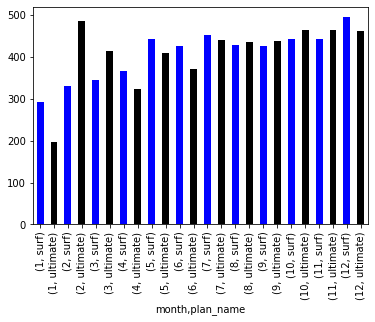

In [128]:
mean_duration.plot(kind='bar', color=['blue', 'black'])

Observamos el promedio de duración de llamadas por mes, en color azul las correspondientes al plan surf y en color negro las correspondientes al plan ultimate.

De este gráfico concluimos que el promedio de duración de las llamadas para ambos planes es similar salvo en los primeros 2 meses del año, donde en enero el plan ultimate tiene una duración inferior al plan surf y al mes siguiente se observa lo contrario, una duración promedio mayor para el plan ultimate.

<AxesSubplot:xlabel='month'>

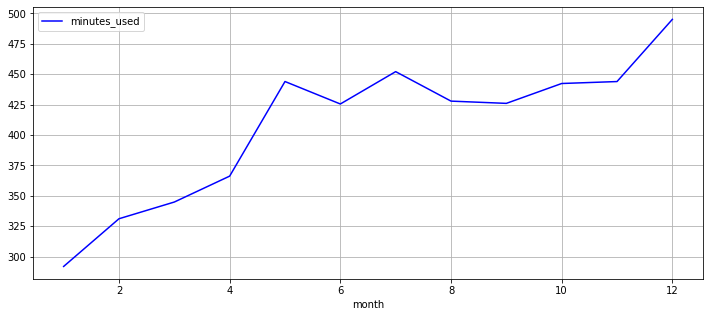

In [167]:
(df_final
     .query('plan_name == "surf"')
     .pivot_table(index='month', values='minutes_used', aggfunc='mean')
     .plot(kind='line', grid=True, figsize=(12, 5), color='blue')
)

<AxesSubplot:xlabel='month'>

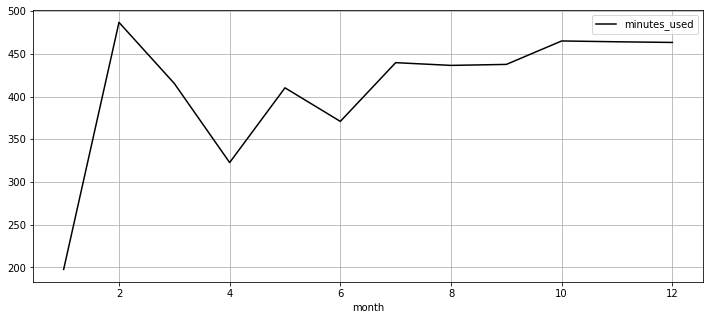

In [168]:
(df_final
     .query('plan_name == "ultimate"')
     .pivot_table(index='month', values='minutes_used', aggfunc='mean')
     .plot(kind='line', grid=True, figsize=(12, 5), color='black')
)

Adicionalmente, observamos que en general, el plan ultimate tiene un promedio mayor de minutos por mes contra el plan surf.

In [129]:
# Compara el número de minutos que los usuarios de cada plan requieren cada mes. Traza un histograma.

mean_duration = df_final.groupby('plan_name').minutes_used.mean()

print(mean_duration)

plan_name
surf        445.775424
ultimate    442.512953
Name: minutes_used, dtype: float64


<AxesSubplot:xlabel='plan_name'>

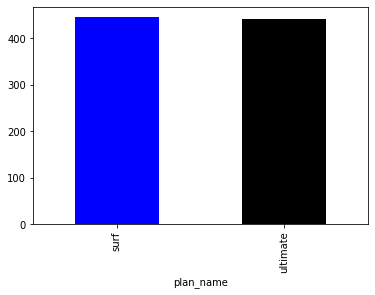

In [130]:
mean_duration.plot(kind='bar', color=['blue', 'black'])

En este gráfico observamos que la duración promedio de las llamadas es muy similar en ambos planes, ligeramente mayor en el plan surf.

In [131]:
# Calcula la media y la varianza de la duración mensual de llamadas.
var_duration = df_final.groupby('plan_name').minutes_used.var()
var_duration

plan_name
surf        55321.412627
ultimate    62288.399053
Name: minutes_used, dtype: float64

In [132]:
median_duration = df_final.groupby('plan_name').minutes_used.median()
median_duration

plan_name
surf        439
ultimate    424
Name: minutes_used, dtype: int64

In [133]:
std_duration = df_final.groupby('plan_name').minutes_used.std()
std_duration

plan_name
surf        235.205044
ultimate    249.576439
Name: minutes_used, dtype: float64

Con el calculo de la varianza y la desviación estandar observamos que para el plan surf los valores de duración promedio de las llamadas se encuentran más cerca a la media que para el plan ultimate. Con la mediana observamos que plan surf tiene una duración mayor de llamada usualmente.

<AxesSubplot:xlabel='month', ylabel='minutes_used'>

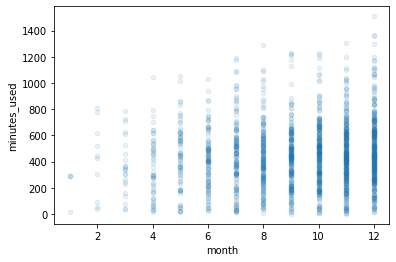

In [134]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas.
df_final.plot(x='month', y='minutes_used', kind='scatter',alpha=0.1)

 Observamos que en los últimos meses del año hay una concentración mayor de llamadas en ambos planes y el comportamiento es bastante similar en ambos planes.

### Mensajes

In [135]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
mean_messages = df_final.groupby('plan_name').messages_used.mean()

print(mean_messages)

plan_name
surf        39.489831
ultimate    46.455959
Name: messages_used, dtype: float64


<AxesSubplot:xlabel='plan_name'>

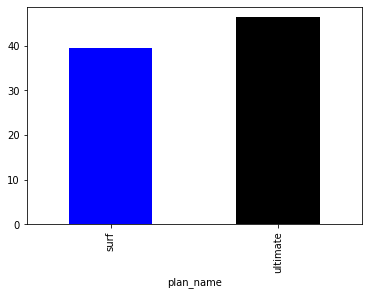

In [136]:
mean_messages.plot(kind='bar', color=['blue', 'black'])

<AxesSubplot:xlabel='month,plan_name'>

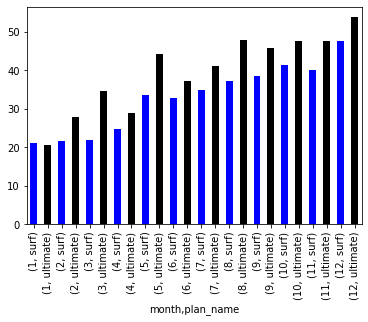

In [137]:
mean_messages = df_final.groupby(['month','plan_name']).messages_used.mean()
mean_messages.plot(kind='bar', color=['blue', 'black'])

Observamos que mensualmente, en el plan ultimate se envían un promedio mayor de mensajes de texto.

Observamos que el plan ultimate tiene un promedio de mensajes mayor que el plan surf.

<AxesSubplot:xlabel='month'>

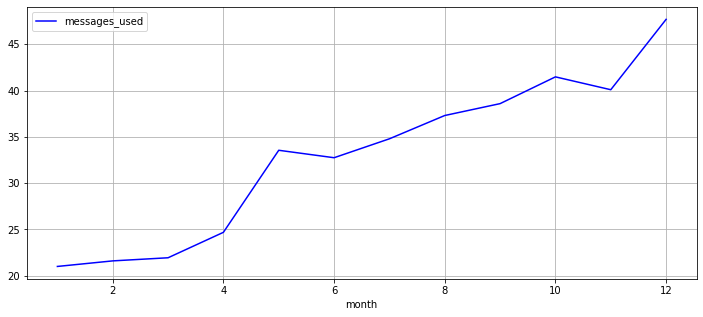

In [160]:
(df_final
     .query('plan_name == "surf"')
     .pivot_table(index='month', values='messages_used', aggfunc='mean')
     .plot(kind='line', grid=True, figsize=(12, 5), color='blue')
)

<AxesSubplot:xlabel='month'>

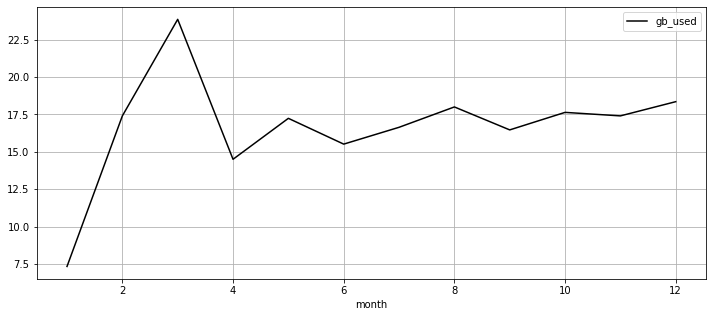

In [161]:
(df_final
     .query('plan_name == "ultimate"')
     .pivot_table(index='month', values='gb_used', aggfunc='mean')
     .plot(kind='line', grid=True, figsize=(12, 5), color='black')
)

### Internet

In [138]:
# Compara la cantidad de tráfico de internet consumido por usuarios por plan
mean_gb = df_final.groupby('plan_name').gb_used.mean()

print(mean_gb)

plan_name
surf        16.752542
ultimate    17.343696
Name: gb_used, dtype: float64


<AxesSubplot:xlabel='plan_name'>

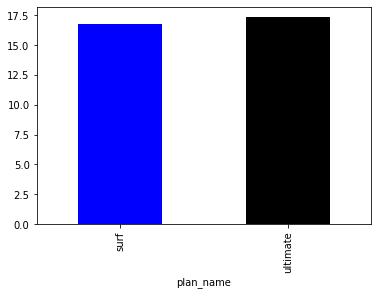

In [139]:
mean_gb.plot(kind='bar', color=['blue', 'black'])

<AxesSubplot:xlabel='month,plan_name'>

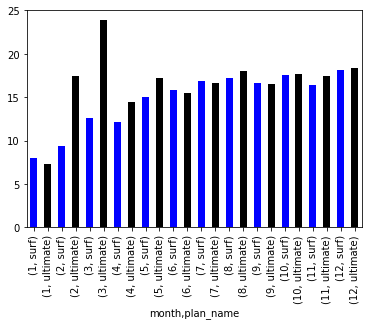

In [148]:
mean_gb = df_final.groupby(['month','plan_name']).gb_used.mean()
mean_gb.plot(kind='bar', color=['blue', 'black'])

Observamos que ambos planes tienen un uso de datos promedio bastante similar, en el caso del plan ultimate es ligeramente mayor.

Al analizar mes con mes se observa que el plan ultimate tiene un uso mucho mayor, incluso casi el doble, que el plan surf durante los meses de febrero y marzo únicamente.

<AxesSubplot:xlabel='month'>

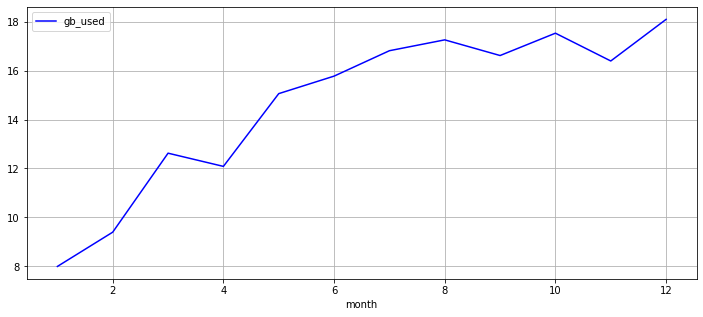

In [163]:
(df_final
     .query('plan_name == "surf"')
     .pivot_table(index='month', values='gb_used', aggfunc='mean')
     .plot(kind='line', grid=True, figsize=(12, 5), color='blue')
)

<AxesSubplot:xlabel='month'>

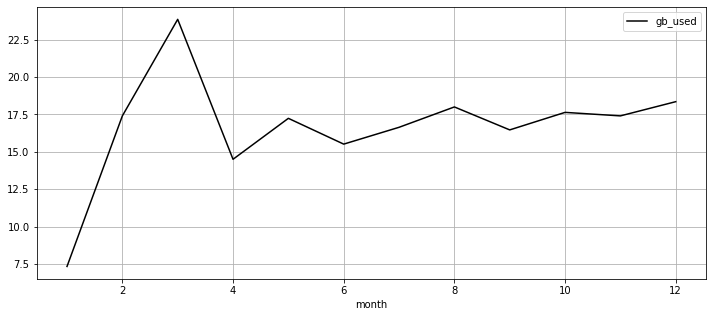

In [164]:
(df_final
     .query('plan_name == "ultimate"')
     .pivot_table(index='month', values='gb_used', aggfunc='mean')
     .plot(kind='line', grid=True, figsize=(12, 5), color='black')
)

## Ingreso

In [174]:
mean_payment = df_final.groupby('plan_name').payment.mean()

mean_payment

plan_name
surf        60.415839
ultimate    72.248705
Name: payment, dtype: float64

<AxesSubplot:xlabel='plan_name'>

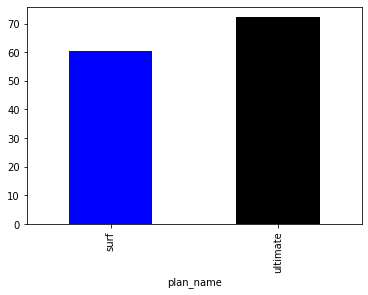

In [142]:
mean_payment.plot(kind='bar', color=['blue', 'black'])

<AxesSubplot:xlabel='month,plan_name'>

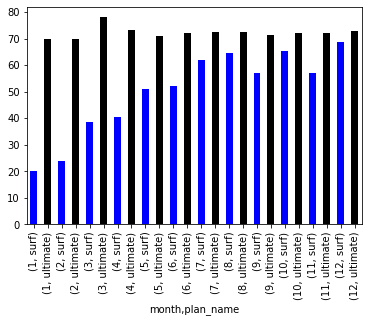

In [143]:
mean_payment = df_final.groupby(['month','plan_name']).payment.mean()

mean_payment.plot(kind='bar', color=['blue', 'black'])

Al observar el comportamiento mes a mes, se observa que el plan ultimate tiende a tener un ingreso mayor, pero en los primeros meses del año, este ingreso se ve en más del doble comparado con el plan surf.

Observamos que el ingreso promedio del plan ultimate es mayor al ingreso promedio del plan surf.

<AxesSubplot:xlabel='month'>

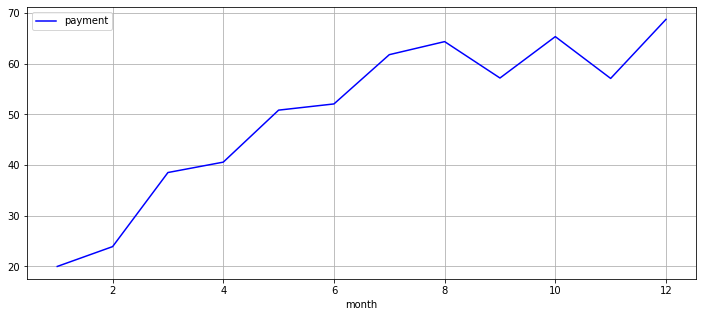

In [165]:
(df_final
     .query('plan_name == "surf"')
     .pivot_table(index='month', values='payment', aggfunc='mean')
     .plot(kind='line', grid=True, figsize=(12, 5), color='blue')
) 

<AxesSubplot:xlabel='month'>

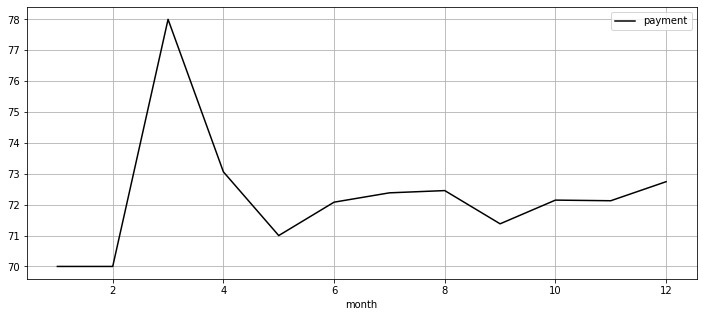

In [166]:
(df_final
     .query('plan_name == "ultimate"')
     .pivot_table(index='month', values='payment', aggfunc='mean')
     .plot(kind='line', grid=True, figsize=(12, 5), color='black')
) 

De los lineplots observamos que el plan surf tiende a tener un uso que va incrementando de manera constante a lo largo del año. En el caso del plan ultimate observamos un pico en el mes de marzo, para después volver a disminuir a valores medianamente constantes por el resto del año.

## Probar las hipótesis estadísticas.

In [68]:
df_final_surf = df_final[df_final['plan_name'] == 'surf']

In [69]:
df_final_ultimate = df_final[df_final['plan_name'] == 'ultimate']

In [70]:
df_final_surf['mean_payment'] = df_final_surf['payment'].mean()
df_final_ultimate['mean_payment'] = df_final_ultimate['payment'].mean()

/tmp/ipykernel_88/1690984068.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_surf['mean_payment'] = df_final_surf['payment'].mean()
/tmp/ipykernel_88/1690984068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_ultimate['mean_payment'] = df_final_ultimate['payment'].mean()


In [71]:
alpha = 0.05 # el nivel de significancia estadística crítica
# si el valor p es menor que alfa, rechazamos la hipótesis

df_final_surf = df_final_surf['mean_payment']
df_final_ultimate = df_final_ultimate['mean_payment']

results = st.ttest_ind(df_final_surf, df_final_ultimate)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula") 

p-value:  0.0
Rechazamos la hipótesis nula


La hipóstesis nula es que el ingreso promedio de ambos planes es similar, la hipóstesis alternativa es que el ingreso promedio difiere entre ambos planes.

Observamos que el ingreso promedio de ambos planes es muy similar

In [72]:
# Prueba las hipótesis
df_final_NY_NJ = df_final.query('city in ("Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA", "New York-Newark-Jersey City, NY-NJ-PA MSA", "Buffalo-Cheektowaga, NY MSA", "Albany-Schenectady-Troy, NY MSA", "Rochester, NY MSA")')
df_final_others = df_final.query('city != ("Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA", "New York-Newark-Jersey City, NY-NJ-PA MSA", "Buffalo-Cheektowaga, NY MSA", "Albany-Schenectady-Troy, NY MSA", "Rochester, NY MSA")')

In [73]:
df_final_NY_NJ['mean_payment'] = df_final_NY_NJ['payment'].mean()
df_final_others['mean_payment'] = df_final_others['payment'].mean()

/tmp/ipykernel_88/3719261961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_NY_NJ['mean_payment'] = df_final_NY_NJ['payment'].mean()
/tmp/ipykernel_88/3719261961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_others['mean_payment'] = df_final_others['payment'].mean()


In [171]:
df_final_NY_NJ.describe()

count    3.640000e+02
mean     6.214113e+01
std      1.423042e-14
min      6.214113e+01
25%      6.214113e+01
50%      6.214113e+01
75%      6.214113e+01
max      6.214113e+01
Name: mean_payment, dtype: float64

In [173]:
df_final_others.describe()

count    1395.000000
mean       64.876932
std         0.000000
min        64.876932
25%        64.876932
50%        64.876932
75%        64.876932
max        64.876932
Name: mean_payment, dtype: float64

In [74]:
alpha = 0.05

df_final_NY_NJ = df_final_NY_NJ['mean_payment']
df_final_others = df_final_others['mean_payment']

results = st.ttest_ind(df_final_NY_NJ,df_final_others)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula") 

p-value:  0.0
Rechazamos la hipótesis nula


Para esta prueba, la hipótesis nula es que el ingreso promedio para la región NY-NJ es muy similar al resto de ciudades, la hipótesis alternativa es que este ingreso es distinto para esta región y el resto de ellas.

Observamos que el ingreso promedio para la región NY-NJ es muy similar al del resto de ciudades.

Este comportamiento puede deberse a que la cantidad de usuarios en la región de NY-NJ es mucho mayor a la cantidad de usuarios en el resto de regiones.

## Conclusión general

Para poder realizar un análisis adecuado conforme a los parámetros establecidos para los planes, se tuvo que redondear el valor de los llamadas desde el inicio, pero para el caso de los gb, se tuvo que realizar una conversión, pero el redondeo se realizó hasta que se calculo el uso por mes para calcular el ingreso.

Adicionalmente, varios valores se tuvieron que cambiar de tipo para poder trabajar con las fechas, así como generar nuevos dataframes con la información que nos resultaba valiosa para el análisis en un último dataframe que se denominó df_final.

Con este proyecto observamos que para los planes surf y ultimate la duración de las llamadas tiende a ser bastante similar, en cuanto a los mensajes, con el plan ultimate los usuarios tienden a hacer un mayor uso de mensajes.

También observamos que los meses con mayor concentración de mensajes se encuentran a fin de año.

Por último, observamos que ambos planes tienen un promedio de ingresos bastante similar, así como la gran mayoría de ciudades tienen igualmente un ingreso promedio similar.